In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from functorch import make_functional, vmap, jacrev, jacfwd
import numpy as np
import torchopt
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

NOTE: Redirects are currently not supported in Windows or MacOs.


In [28]:
from oneshot_transfer_learning.model import Multihead
from oneshot_transfer_learning.training import train_model
from oneshot_transfer_learning.oneshot_transfer_learning import M_matrix, compute_W, one_shot_TL, loss_TL

### One Shot Transfer Learning for Exemple 1
$$
\begin{align*}
\frac{dx}{dt} &=  -\alpha x + \beta y^2,\quad \frac{dy}{dt} &= x - \beta y^2 + 1 \text{ with } \beta \in [0, 1] \text{ and } \alpha \text{ the stiffness parameter}
\end{align*}
$$


Then by $\beta$-perturbation expansion $x=\sum_{i=0}^{\infty}\beta^iX_i$ and $y=\sum_{i=0}^{\infty}\beta^iY_i$ with have these systems for the various power of $\lambda^i$ with $i=0, 1, 2, ...$
$$
\begin{align*}
\frac{dX_i}{dt} + \alpha X_i &= f_i, \quad \frac{dY_i}{dt} - X_i  &= -f_i + (1 \text{ if } i=0)
\end{align*} \\

\begin{align*}

f_i = \begin{cases}
0 \ \text{if} \ i \in \{0\} \\
\sum_{a+b=i-1}^{0<a,b,<p}\phi(a,b)y_ay_b \ \ \text{with} \ \phi(a,b)=\begin{cases}
1 \ \text{if} \ a=b \\
2 \ \text{otherwise}
\end{cases}
\end{cases}
\end{align*}
$$

So the linears systems are A = $
\begin{bmatrix}
  \alpha & 0 \\
  -1 & 0
\end{bmatrix}
$ and f = $\begin{bmatrix}
  f_i \\
  -f_i + (1 \text{ if } i=0)
\end{bmatrix}$


In [5]:
# construct a model of 10 heads
k=10
alpha_bounds = (1, 5)

def generate_parameters(k, alpha_bounds = alpha_bounds, seed=14):
  alpha_list = np.zeros(k)
  np.random.seed(seed)
  for i in range(k):
    alpha_list[i] = np.random.uniform(alpha_bounds[0], alpha_bounds[1])
  return alpha_list

# generate the parameter head
alpha_list = generate_parameters(k)
IC_list = [[2., 0.] for i in range(k)]

# Force Function
def force_function():
  def force(x):
    if isinstance(x, float):
      return np.array([0, 1])
    return torch.stack([torch.zeros_like(x), torch.ones_like(x)]).T
  return force
# Construct a list forcing function from different head
forcing_functions = [force_function() for i in range(k)]

# A Head List
# Construct a tensor that stores k matrice A (k, 2, 2) from the head parameter
def get_A(alpha, tensor=True):
  if tensor:
    return torch.Tensor([[alpha, 0], [-1, 0]])
  else:
    return np.array([[alpha, 0], [-1, 0]])
A_matrices = torch.zeros(k, 2, 2)
for i in range(k):
  A_matrices[i] = get_A(alpha_list[i])
A_matrices

tensor([[[ 3.0558,  0.0000],
         [-1.0000,  0.0000]],

        [[ 4.0927,  0.0000],
         [-1.0000,  0.0000]],

        [[ 4.4817,  0.0000],
         [-1.0000,  0.0000]],

        [[ 1.0322,  0.0000],
         [-1.0000,  0.0000]],

        [[ 2.2389,  0.0000],
         [-1.0000,  0.0000]],

        [[ 4.8304,  0.0000],
         [-1.0000,  0.0000]],

        [[ 3.0525,  0.0000],
         [-1.0000,  0.0000]],

        [[ 2.2731,  0.0000],
         [-1.0000,  0.0000]],

        [[ 3.1568,  0.0000],
         [-1.0000,  0.0000]],

        [[ 1.8850,  0.0000],
         [-1.0000,  0.0000]]])

In [43]:
# Model
reparametrization = False
model = Multihead(k=k, IC_list=IC_list)
fmodel, params = make_functional(model)

In [44]:
##make the model fully functional and define the jacobian function
##this function only returns the output of the network
def f_multihead(x, params, reparametrization=reparametrization):
  x_ = x.unsqueeze(0)
  res = fmodel(params, x_, reparametrization)[0].squeeze(0)
  return res

#if input x contains B elements
##the output of this function will be a tensor of shape (B, k, 2)
##where k is the number of heads
f_multihead_vmap = vmap(f_multihead, in_dims=(0, None), randomness="same")

##define gradient of the NN
dfdx_multihead = vmap(jacfwd(f_multihead), in_dims=(0, None), randomness="same")

##this function returns the hidden state of the network
##the hidden state depends on: 1. time 2. parameters of the network
def hidden_state(x, params):
  x_ = x.unsqueeze(0)
  H = fmodel(params, x_)[1].squeeze(0)
  return H

##returns the batched hidden states of shape (B, 512)
hidden_state_vmap = vmap(hidden_state, in_dims=(0, None), randomness="same")

#define gradient of the hidden state H'
#returns the batched gradients of the hidden states of shape (B, 512)
dHdx = vmap(jacrev(hidden_state), in_dims=(0, None), randomness="same")

In [23]:
#define optimization configuration
batch_size = 200 ##number of colocation points sampled in each iteration
num_iter = 2000 #maximum number of iterations
learning_rate = 2e-4
domain = (0, 2) #logistic equation domain
optimizer = optimizer = torchopt.FuncOptimizer(torchopt.adam(lr=learning_rate))

new_params, loss_trace, colocation_trace, BC_trace = train_model(num_iter, params, f_multihead_vmap, dfdx_multihead,
                                                                batch_size, domain,  A_matrices, IC_list, forcing_functions, 
                                                                optimizer, display_every=100, decay=True, gamma=0.96, every=100)

Iteration 99 with loss 0.03777403384447098, colocation: 0.03444279357790947, BC: 0.00333123910240829
Iteration 199 with loss 0.0030797095969319344, colocation: 0.003011539811268449, BC: 6.816968380007893e-05
Iteration 299 with loss 0.0012660695938393474, colocation: 0.0012482759775593877, BC: 1.7793656297726557e-05
Iteration 399 with loss 0.0007116303313523531, colocation: 0.0007064450182951987, BC: 5.185303962207399e-06
Iteration 499 with loss 0.0006381148705258965, colocation: 0.0006235394976101816, BC: 1.4575392015103716e-05
Iteration 599 with loss 0.0007183420821093023, colocation: 0.000706975522916764, BC: 1.1366546459612437e-05
Iteration 699 with loss 0.000320486375130713, colocation: 0.0003016633272636682, BC: 1.8823047867044806e-05
Iteration 799 with loss 0.00022373780666384846, colocation: 0.00021567886869888753, BC: 8.058938874455635e-06
Iteration 899 with loss 0.0001940179499797523, colocation: 0.00019317683472763747, BC: 8.41114172089874e-07
Iteration 999 with loss 0.000345

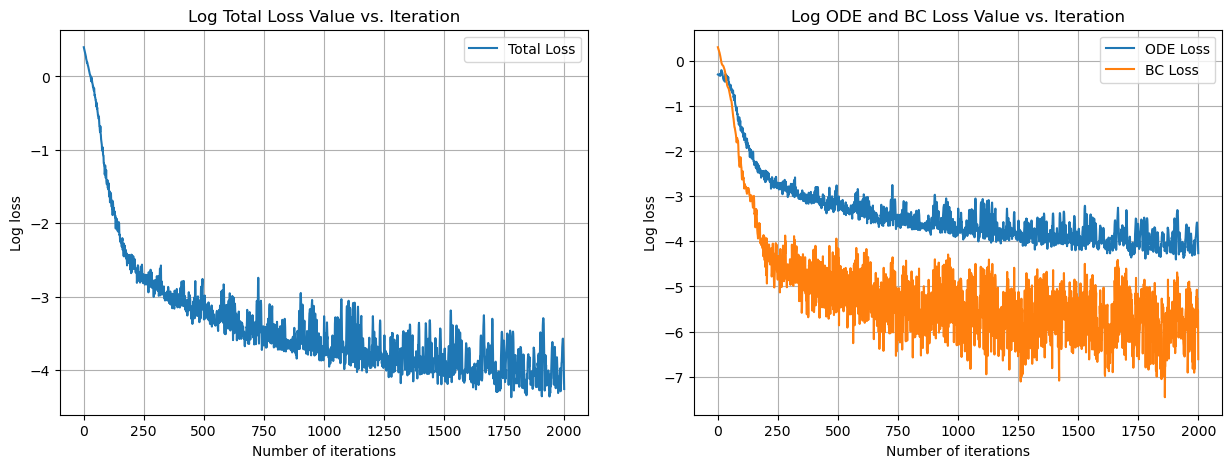

In [45]:
##plot the loss value
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(range(1, num_iter+1), np.log10(loss_trace), label='Total Loss');
ax[1].plot(range(1, num_iter+1), np.log10(colocation_trace), label='ODE Loss');
ax[1].plot(range(1, num_iter+1), np.log10(BC_trace), label="BC Loss");

ax[0].set_xlabel("Number of iterations");
ax[0].set_ylabel("Log loss");
ax[0].set_title("Log Total Loss Value vs. Iteration");
ax[0].grid();
ax[0].legend();
ax[1].set_xlabel("Number of iterations");
ax[1].set_ylabel("Log loss");
ax[1].set_title("Log ODE and BC Loss Value vs. Iteration");
ax[1].grid();
ax[1].legend();

In [46]:
# Get the network solution
X_grid = torch.FloatTensor(np.linspace(domain[0], domain[1], 200))
Y_NN = f_multihead_vmap(X_grid, new_params) #shape (100, 10, 2)
Y_NN = Y_NN.transpose(0, 1)

# Get numerical solutions
def RHS_decorator(A, force):
  def func(t, y):
    y = np.array(y).reshape(2)
    if isinstance(force, np.ndarray):
      return -A@y + force
    else: return -A@y + force(float(t))
  return func

RHS_functions = [RHS_decorator(A, f) for A, f in zip(A_matrices, forcing_functions)]
numerical_result = [solve_ivp(RHS_functions[i], domain,
                    np.array(IC_list[0]), t_eval=X_grid, method = 'DOP853') for i in range(k)]

### Plot the Network Solution together with the Numerical Solution

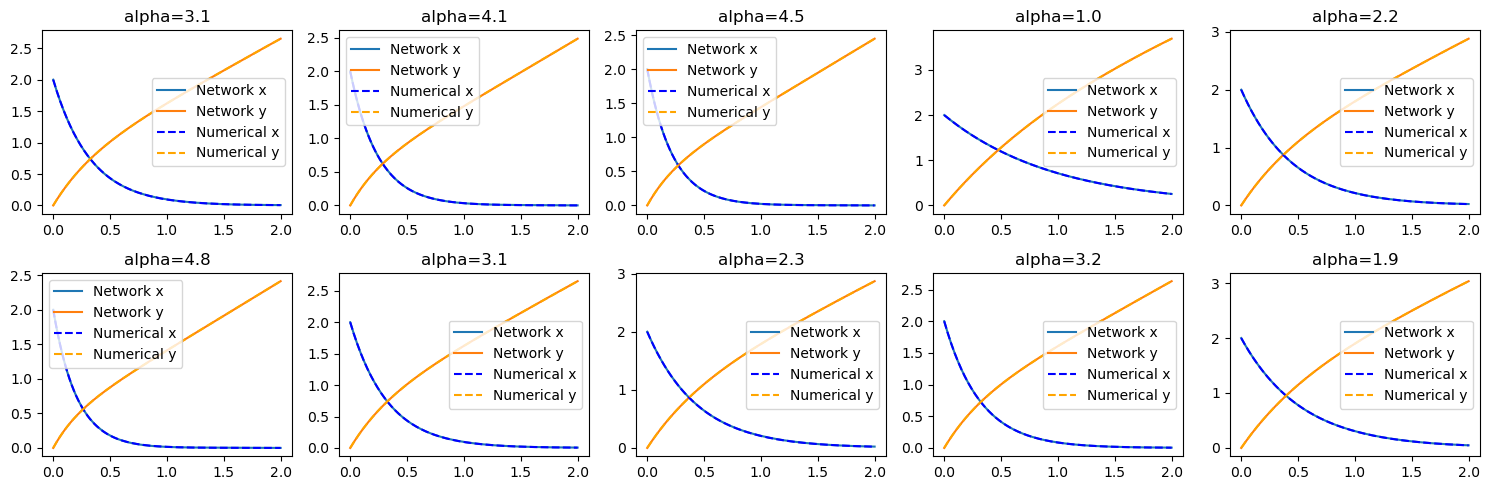

In [47]:
fig, ax = plt.subplots(k//5, 5, figsize=(15, 5));
for i in range(k):
  j = i//5; l = i%5
  ax[j][l].plot(X_grid, Y_NN[i][:,0].detach().numpy(), label="Network x");
  ax[j][l].plot(X_grid, Y_NN[i][:,1].detach().numpy(), label='Network y');
  ax[j][l].plot(X_grid, numerical_result[i].y[0], '--', c='blue',label='Numerical x');
  ax[j][l].plot(X_grid, numerical_result[i].y[1], '--', c='orange',label='Numerical y');
  ax[j][l].set_title(f"alpha={alpha_list[i]:.1f}")
  ax[j][l].legend();
fig.tight_layout()

## One-Shot Transfer Learning

Try out the following unseen parameter
$
\alpha = 5,
$

In [48]:
# get the network solution for this parameter set
alpha_transfer = 30; A_transfer = get_A(alpha=alpha_transfer, tensor=False)
IC_transfer = IC_list[0]
force_function_transfer = forcing_functions[0]
analytic_result, W = one_shot_TL(X_grid, new_params, hidden_state_vmap, dHdx,
                                 A_transfer, force_function_transfer, IC_transfer,
                                 reparametrization)

127839890184.48131


In [49]:
# this function computes the numerical solution on X_grid values
def compute_numerical_solution(A, IC, force, X_grid, domain):
  numerical_solution = solve_ivp(RHS_decorator(A, force), domain, np.array(IC),
                             t_eval=X_grid, method='RK45')
  return numerical_solution
numerical_solution = compute_numerical_solution(A_transfer, IC_transfer, force_function_transfer, X_grid, domain)

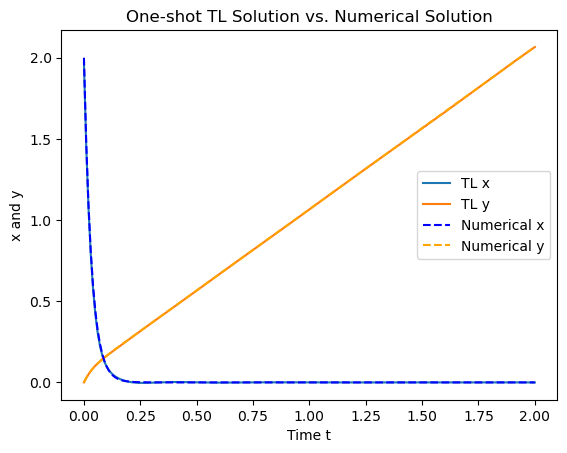

In [50]:
plt.plot(X_grid, analytic_result[:,0], label='TL x');
plt.plot(X_grid, analytic_result[:,1], label='TL y')
plt.plot(X_grid, numerical_solution.y[0], '--', c='blue', label="Numerical x");
plt.plot(X_grid, numerical_solution.y[1], '--', c='orange', label="Numerical y");
plt.legend();
plt.xlabel("Time t");
plt.ylabel("x and y");
plt.title("One-shot TL Solution vs. Numerical Solution");

Now we need to find a way to quantatively measure the transfer-learning results. We will define the previous loss function for the TL learnt network.

In [51]:
total_loss, loss_colo, loss_BC = loss_TL(X_grid, new_params, hidden_state_vmap, dHdx, A_transfer, force_function_transfer, IC_transfer, W)
print("The loss statistics of the previous parameter set is:")
print("Weighted Total Loss: {}".format(total_loss))
print("Colocation Loss: {}".format(loss_colo))
print("BC loss: {}".format(loss_BC))

The loss statistics of the previous parameter set is:
Weighted Total Loss: 0.022157382402395814
Colocation Loss: 0.02090292970063528
BC loss: 0.001254452701760535


## Try to Solve General Equation

In [52]:
alpha_transfer = 30; beta = 0.1
domain = (0, 2.0);
X_grid = torch.FloatTensor(np.arange(domain[0], domain[1], 0.01))

In [53]:
def general_solution(alpha, beta, u0, domain, t_eval):
  def F(t, y):
    return [-alpha*y[0]+ beta*y[1]**2,
            y[0] - beta*y[1]**2 + 1]
  solution = solve_ivp(F, domain, u0, t_eval=t_eval)
  return solution
solution = general_solution(alpha_transfer, beta, IC_list[0], domain, X_grid)

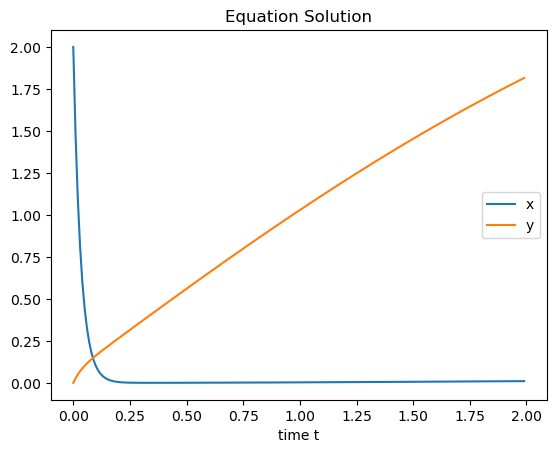

In [54]:
##plot the numerical solution
plt.plot(solution.t, solution.y[0], label='x');
plt.plot(solution.t, solution.y[1], label='y');
plt.xlabel("time t");
plt.title("Equation Solution");
plt.legend();

### How to set the initial values of the p system?

First idea is to make the initial values the same across all systems.

then we have:

$$x_0  = \frac{x^{(0)}}{\sum_{i=0}^p \beta^{i}}$$

In [55]:
A_linear = get_A(alpha=alpha_transfer, tensor=False)
A_linear

array([[30,  0],
       [-1,  0]])

In [56]:
##this function computes the uniform initial condition value for all p systems
def compute_initial(x0, beta, p):
  denominator = 0
  for i in range(p+1):
    denominator += beta**i
  return x0/denominator

def x0_function_decorator(W, params, tensor=False):
  def x0_function(x):
    if tensor:
      return hidden_state_vmap(x, params)[:, :256]@torch.from_numpy(W).float()
    return hidden_state_vmap(x, params).detach().numpy()[:, :256]@W
  return x0_function

def y0_function_decorator(W, params, tensor=False):
  def y0_function(x):
    if tensor:
      return hidden_state_vmap(x, params)[:, 256:]@torch.from_numpy(W).float()
    return hidden_state_vmap(x, params).detach().numpy()[:, 256:]@W
  return y0_function

def xi_function_decorator(W, tensor=False):
  def xi_function(x):
     if tensor:
        return hidden_state_vmap(x, new_params)[:, :256]@torch.from_numpy(W).float()
     return hidden_state_vmap(x, new_params).detach().numpy()[:, :256]@W
  return xi_function

def yi_function_decorator(W, tensor=False):
  def yi_function(x):
     if tensor:
        return hidden_state_vmap(x, new_params)[:, 256:]@torch.from_numpy(W).float()
     return hidden_state_vmap(x, new_params).detach().numpy()[:, 256:]@W
  return yi_function

def final_function_decorator(function_list, beta):
  def final_function(x):
    result = 0
    for i in range(len(function_list)):
      result += (beta**i)*function_list[i](x)
    return result
  return final_function

In [57]:
import time
##this function uses one-shot TL technique to solve the nonlinear Van der Pol equation (the x0' is set to 0)
##Parameters:
## x0: the initial value of the duffing equation
## lambda: parameter lamnda in the duffing equation
## p: number of linear systems to solve to approximate the Duffing Equation
## domain: the range at which the Duffing equation will be solved
## N: number of data points used to compute the result
## v0: initial velocity, default 0

def force_func_index(n):
    solution_index = [] # ind1, ind2, ind3, coeff
    for a in range(n+1):
        for b in range(a+1):
                if ((a+b)==n):
                    if a==b:
                        solution_index.append([a, b, 1])
                    else:
                        solution_index.append([a, b, 2])
    return solution_index

def build_force_function(n):
    list_force_index = []
    for i in range(n+1):
        list_force_index.append(force_func_index(i))
    return list_force_index

def solve_perturbation_TL(beta, p, domain, N, alpha, A, force, IC, params,
                       verbose=True, tensor=False, numerical_sol=False):

  x0_initials = compute_initial(IC[0], beta, p)
  v0_initials = compute_initial(IC[1], beta, p)
  IC_pertubation = [x0_initials, v0_initials]

  if verbose:
    print("Using uniform initial values of: x0={}, v0={}".format(x0_initials, v0_initials))
  x = torch.linspace(domain[0] + (domain[1]-domain[0])/N, domain[1], N)
  M = M_matrix(x, params, hidden_state_vmap, dHdx, A); Minv = np.linalg.pinv(M)

  ##compute the analytic W
  W = compute_W(x, params, hidden_state_vmap, dHdx, A, force, IC_pertubation, Minv)
  x0_function = x0_function_decorator(W, params, tensor=tensor)
  y0_function = y0_function_decorator(W, params, tensor=tensor)
  numerical = compute_numerical_solution(A, IC_pertubation, force, x, domain)
  W_list = [W]; x_function_list = [x0_function]; y_function_list = [y0_function]; numercal_solution_list= []
  if numerical_sol:
   numercal_solution_list = [numerical]
  # solve the rest p linear ode system
  # build force function
  list_force_index = build_force_function(p)
  for i in range(1, p+1):
    if verbose:
      print("Solving the {}th linear ode system...".format(i))
  
    # obtain the forcing function
    def force_function(x):
      result = 0
      for force_ind in list_force_index[i-1]:
        result += force_ind[2]*(y_function_list[force_ind[0]](x)*y_function_list[force_ind[1]](x))
      return np.hstack((result, -result))

    def force_function_numerical(x):
      result=0
      for force_ind in list_force_index[i-1]:
        if isinstance(x, float): 
          index = np.argmin(np.abs(numercal_solution_list[0].t- x))
          result += force_ind[2]*(numercal_solution_list[force_ind[0]].y[1][index]*numercal_solution_list[force_ind[1]].y[1][index])
        else:
          result += force_ind[2]*(numercal_solution_list[force_ind[0]].y[1]*numercal_solution_list[force_ind[1]].y[1])
      if isinstance(x, float):
        return np.array([result, -result])
      else:
        return np.hstack((result[:, np.newaxis], -result[:, np.newaxis]))
         
    #compute the analytic W
    s = time.time()
    W = compute_W(x, params, hidden_state_vmap, dHdx, A, force_function, IC_pertubation, Minv)
    e = time.time()
    if verbose:
      print(f"Time to compute W: {e-s:.2f}")
    #obtain the function xi
    x_function_list.append(xi_function_decorator(W, tensor=tensor))
    y_function_list.append(yi_function_decorator(W, tensor=tensor))
    W_list.append(W)
    if verbose:
      print(f"Computing Numerical Solution...")
    if numerical_sol:
      numercal_solution_list.append(compute_numerical_solution(A, IC_pertubation, force_function_numerical, x, domain))
    if verbose:
      print("=======================================================")
  x_final_function = final_function_decorator(x_function_list, beta)
  y_final_function = final_function_decorator(y_function_list, beta)
  return x_final_function, y_final_function, x_function_list, y_function_list, W_list, numercal_solution_list

In [58]:
p = 4
x_final_function, y_final_function, x_function_list, y_function_list, W_list, numerical_solution_list = solve_perturbation_TL(beta, p, domain, 300, alpha_transfer, A_linear, forcing_functions[0], IC_list[0], new_params, verbose=True, tensor=False, numerical_sol=True)

Using uniform initial values of: x0=1.800018000180002, v0=0.0
Solving the 1th linear ode system...
Time to compute W: 1.09
Computing Numerical Solution...
Solving the 2th linear ode system...
Time to compute W: 1.09
Computing Numerical Solution...
Solving the 3th linear ode system...
Time to compute W: 1.06
Computing Numerical Solution...
Solving the 4th linear ode system...
Time to compute W: 1.05
Computing Numerical Solution...


Plot all p+1 linear system solutions. The final solution will be the linear combination of these functions

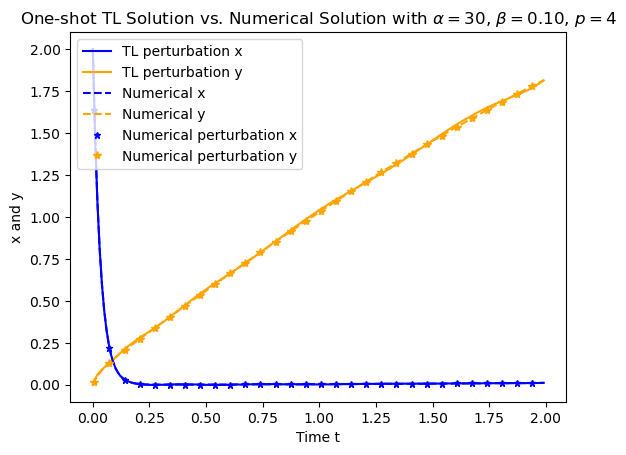

In [59]:
size = len(solution.t)
factor = 1
end = int(size//factor)

plt.plot(X_grid, x_final_function(X_grid), c='blue', label='TL perturbation x');
plt.plot(X_grid, y_final_function(X_grid), c='orange', label='TL perturbation y');

plt.plot(solution.t[:end], solution.y[0][:end], '--', c='blue', label="Numerical x");
plt.plot(solution.t[:end], solution.y[1][:end], '--', c='orange', label="Numerical y");

x_final_function_numerical = sum([(beta)**i*val.y[0] for i, val in enumerate(numerical_solution_list)])
y_final_function_numerical = sum([(beta)**i*val.y[1] for i, val in enumerate(numerical_solution_list)])
size = len(numerical_solution_list[0].t)
factor = 1
end = int(size//factor)
plt.plot(numerical_solution_list[0].t[:end:10], x_final_function_numerical[:end:10], '*', c='blue', label='Numerical perturbation x', markersize=5)
plt.plot(numerical_solution_list[0].t[:end:10], y_final_function_numerical[:end:10], '*', c='orange', label='Numerical perturbation y')

plt.xlabel("Time t");
plt.ylabel("x and y");
plt.title(fr"One-shot TL Solution vs. Numerical Solution with $\alpha={alpha_transfer}$, $\beta={beta:.2f}$, $p={p}$")
#plt.title(f"One-shot TL Solution vs. Numerical Solution with alpha={alpha}, p={p}, lambda={beta:0.2f}")
plt.legend(loc="best");

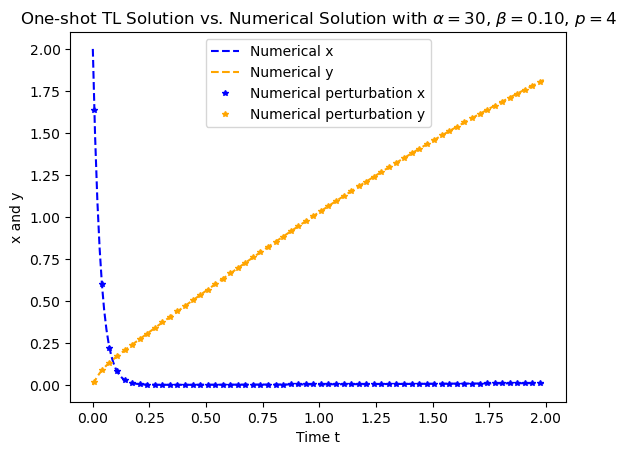

In [108]:
size = len(solution.t)
factor = 1
end = int(size//factor)

# plt.plot(X_grid, x_final_function(X_grid), c='blue', label='TL perturbation x');
# plt.plot(X_grid, y_final_function(X_grid), c='orange', label='TL perturbation y');

plt.plot(solution.t[:end], solution.y[0][:end], '--', c='blue', label="Numerical x");
plt.plot(solution.t[:end], solution.y[1][:end], '--', c='orange', label="Numerical y");

x_final_function_numerical = sum([(beta)**i*val.y[0] for i, val in enumerate(numerical_solution_list)])
y_final_function_numerical = sum([(beta)**i*val.y[1] for i, val in enumerate(numerical_solution_list)])
size = len(numerical_solution_list[0].t)
factor = 1
end = int(size//factor)
plt.plot(numerical_solution_list[0].t[:end:5], x_final_function_numerical[:end:5], '*', c='blue', label='Numerical perturbation x', markersize=4)
plt.plot(numerical_solution_list[0].t[:end:5], y_final_function_numerical[:end:5], '*', c='orange', label='Numerical perturbation y', markersize=4)

plt.xlabel("Time t");
plt.ylabel("x and y");
plt.title(fr"One-shot TL Solution vs. Numerical Solution with $\alpha={alpha_transfer}$, $\beta={beta:.2f}$, $p={p}$")
#plt.title(f"One-shot TL Solution vs. Numerical Solution with alpha={alpha}, p={p}, lambda={beta:0.2f}")
plt.legend(loc="best");

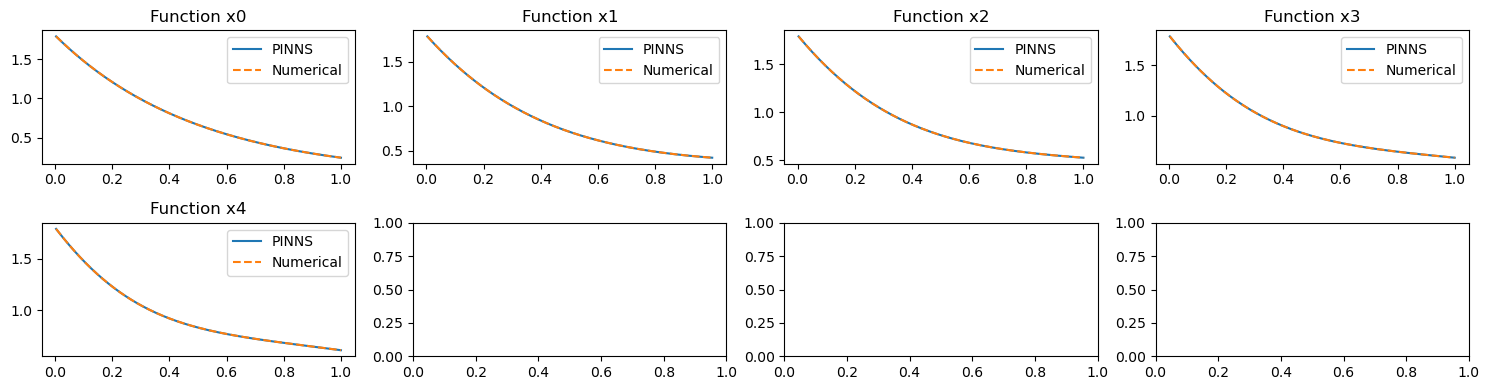

In [29]:
nb_row_plot = (p+1)//4+1 if (p+1)%4!=0 else (p+1)//4
fig, ax = plt.subplots(nb_row_plot, 4, figsize=(15, nb_row_plot*2))
t_eval = numerical_solution_list[0].t
for i in range(p+1):
  j = i//4; k = i%4
  ax[j][k].plot(t_eval, x_function_list[i](torch.tensor(t_eval).float()), label="PINNS")
  ax[j][k].plot(t_eval, numerical_solution_list[i].y[0], '--', label="Numerical")
  #ax[j][k].set_yscale('log')
  ax[j][k].set_title("Function x{}".format(i))
  ax[j][k].legend(loc="best")
fig.tight_layout()

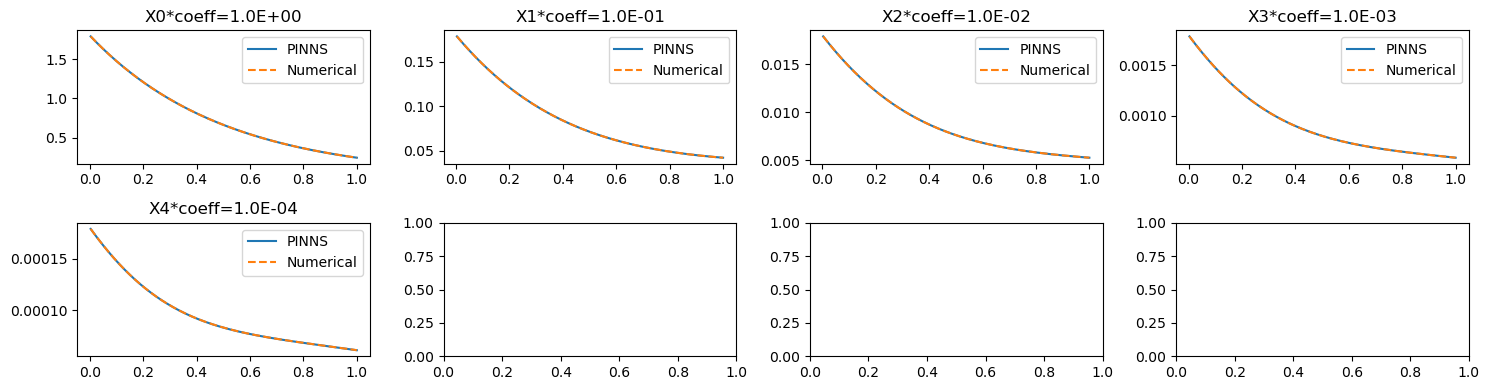

In [30]:
nb_row_plot = (p+1)//4+1 if (p+1)%4!=0 else (p+1)//4
fig, ax = plt.subplots(nb_row_plot, 4, figsize=(15, nb_row_plot*2))
t_eval = numerical_solution_list[0].t
for i in range(p+1):
  j = i//4; k = i%4
  pert_coeff = (beta)**i
  ax[j][k].plot(t_eval, x_function_list[i](torch.tensor(t_eval).float())*pert_coeff, label="PINNS")
  ax[j][k].plot(t_eval, numerical_solution_list[i].y[0]*pert_coeff, '--', label="Numerical")
  ax[j][k].set_title(f"X{i}*coeff={format(pert_coeff, '.1E')}")
  ax[j][k].legend(loc="best")
fig.tight_layout()


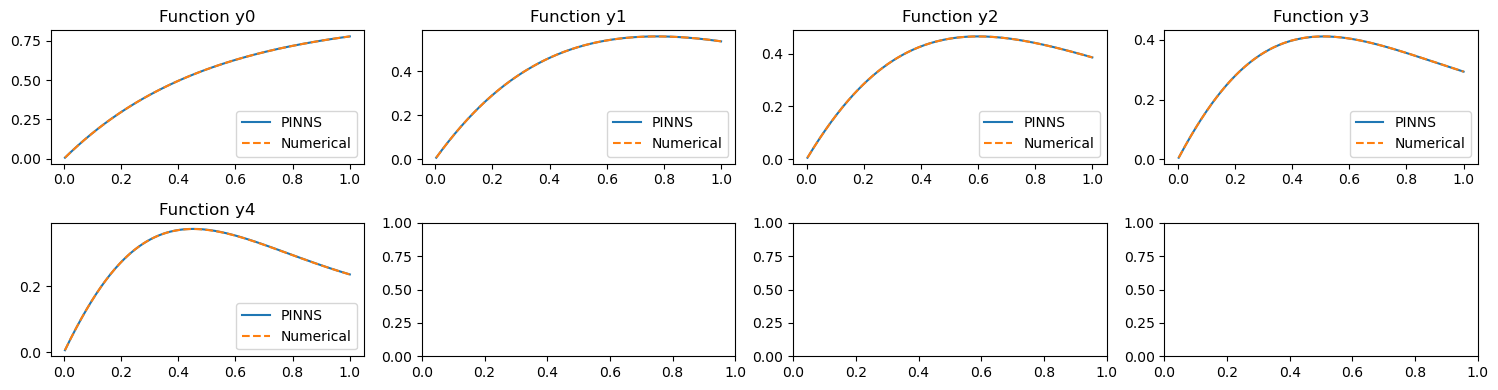

In [31]:
nb_row_plot = (p+1)//4+1 if (p+1)%4!=0 else (p+1)//4
fig, ax = plt.subplots(nb_row_plot, 4, figsize=(15, nb_row_plot*2))
for i in range(p+1):
  j = i//4; k = i%4
  ax[j][k].plot(t_eval, y_function_list[i](torch.tensor(t_eval).float()), label="PINNS")
  ax[j][k].plot(t_eval, numerical_solution_list[i].y[1], '--', label="Numerical")
  ax[j][k].set_title("Function y{}".format(i))
  ax[j][k].legend(loc="best")
fig.tight_layout()

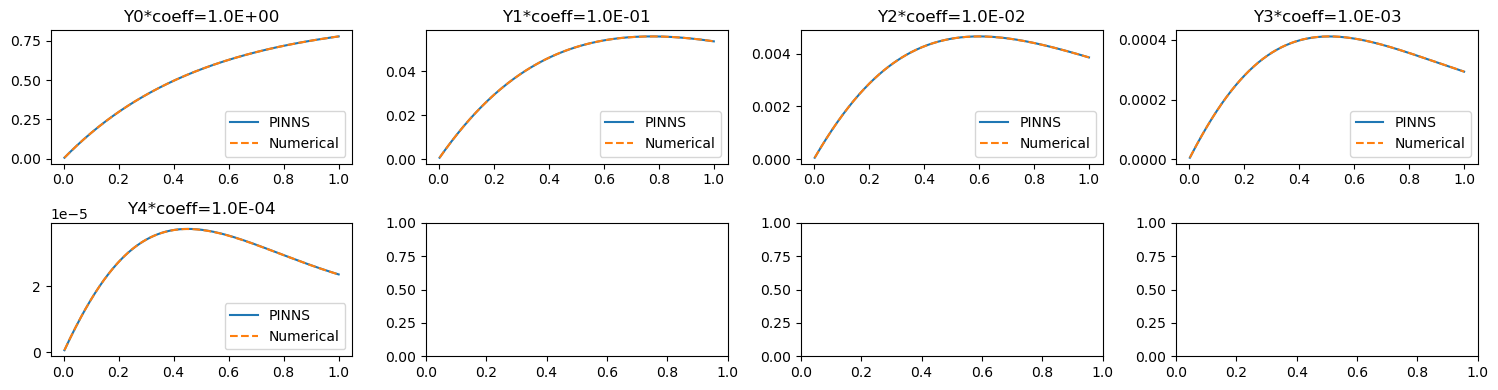

In [32]:
nb_row_plot = (p+1)//4+1 if (p+1)%4!=0 else (p+1)//4
fig, ax = plt.subplots(nb_row_plot, 4, figsize=(15, nb_row_plot*2))
for i in range(p+1):
  j = i//4; k = i%4
  pert_coeff = (beta)**i
  ax[j][k].plot(t_eval, y_function_list[i](torch.tensor(t_eval).float())*pert_coeff, label="PINNS")
  ax[j][k].plot(t_eval, numerical_solution_list[i].y[1]*pert_coeff, '--', label="Numerical")
  ax[j][k].set_title(f"Y{i}*coeff={format(pert_coeff, '.1E')}")
  ax[j][k].legend(loc="best")
fig.tight_layout()


Use different values of p to test how the method performs with different p values.

In [33]:
p_list = [i for i in range(5)]
x_final_List = []; x_function_List_list = []; y_final_List = []; y_function_List_list = []; weights_list = []; numerical_solution_list=[]
for p in p_list:
  print("Solving p = {}".format(p))
  xff, yff, xfl, yfl, w, nsl = solve_perturbation_TL(beta, p, domain, 200, alpha_transfer, A_linear, forcing_functions[0], IC_list[0], new_params, verbose=False, tensor=False, numerical_sol=True)
  x_final_List.append(xff)
  x_function_List_list.append(xfl)
  y_final_List.append(yff)
  y_function_List_list.append(yfl)
  weights_list.append(w)
  numerical_solution_list.append(nsl)

Solving p = 0
Solving p = 1
Solving p = 2
Solving p = 3
Solving p = 4


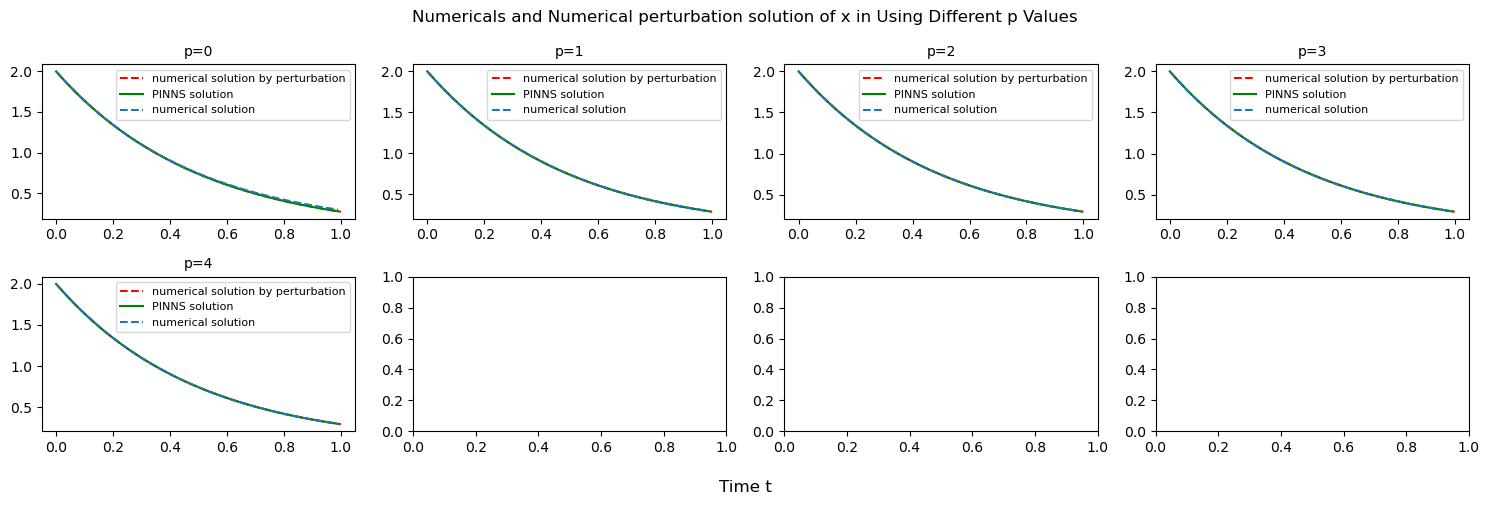

In [34]:
# Numerical - Numerical Perturbation X
nb_row_plot = (len(p_list)+1)//4+1 if (len(p_list))%4!=0 else (len(p_list)+1)//4
fig, ax = plt.subplots(nb_row_plot, 4, figsize=(15, nb_row_plot*2.5))
for i in range(len(p_list)):
  j = i//4; k = i%4
  x_final_function_numerical = sum([(beta)**q*val.y[0] for q, val in enumerate(numerical_solution_list[i])])
  ax[j][k].plot(numerical_solution_list[0][0].t, x_final_function_numerical, '--r', label='numerical solution by perturbation')
  ax[j][k].plot(X_grid, x_final_List[i](X_grid), 'g', label='PINNS solution')
  ax[j][k].plot(solution.t, solution.y[0], '--', label='numerical solution')
  ax[j][k].legend(fontsize=8);
  ax[j][k].set_title("p={}".format(p_list[i]), fontsize=10)
fig.supxlabel("Time t");
fig.suptitle("Numericals and Numerical perturbation solution of x in Using Different p Values");
fig.tight_layout()

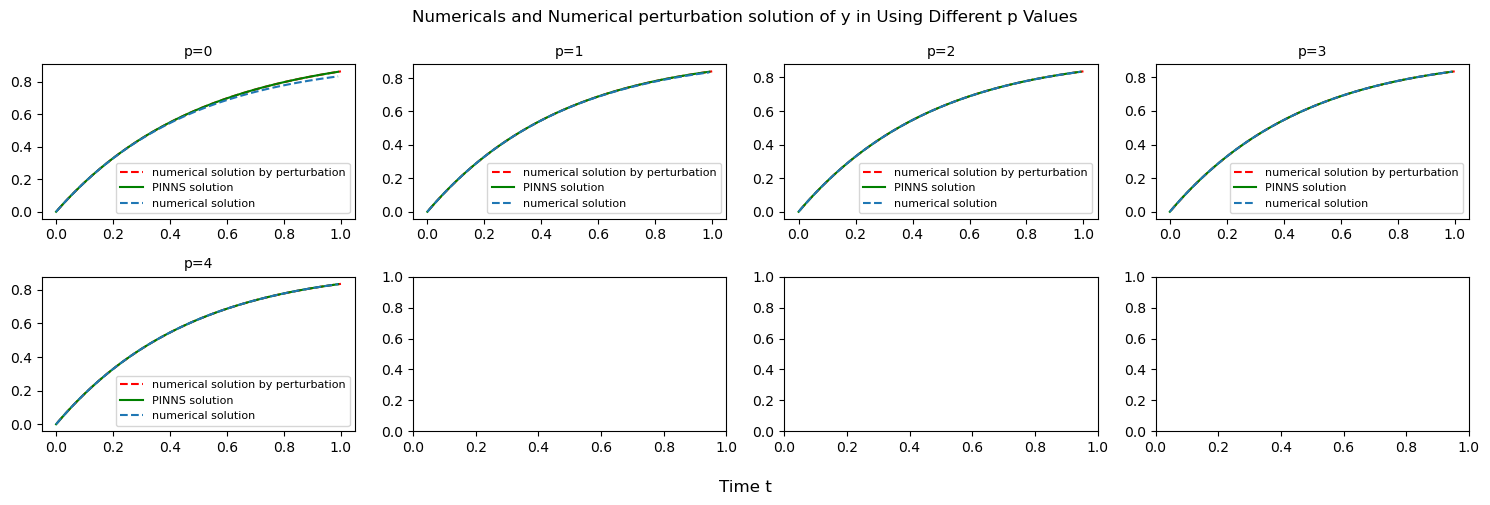

In [35]:
# Numerical - Numerical Perturbation Y
nb_row_plot = (len(p_list)+1)//4+1 if (len(p_list))%4!=0 else (len(p_list)+1)//4
fig, ax = plt.subplots(nb_row_plot, 4, figsize=(15, nb_row_plot*2.5))
for i in range(len(p_list)):
  j = i//4; k = i%4
  y_final_function_numerical = sum([(beta)**q*val.y[1] for q, val in enumerate(numerical_solution_list[i])])
  ax[j][k].plot(numerical_solution_list[0][0].t, y_final_function_numerical, '--r', label='numerical solution by perturbation')
  ax[j][k].plot(X_grid, y_final_List[i](X_grid), 'g', label='PINNS solution')
  ax[j][k].plot(solution.t, solution.y[1], '--', label='numerical solution')
  ax[j][k].legend(fontsize=8);
  ax[j][k].set_title("p={}".format(p_list[i]), fontsize=10)
fig.supxlabel("Time t");
fig.suptitle("Numericals and Numerical perturbation solution of y in Using Different p Values");
fig.tight_layout()

# END